In [1]:
#%%
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xarray as xr

import subprocess
from datetime import timedelta
from cht_hurrywave.hurrywave import HurryWave
from cht_hurrywave.grid import HurryWaveGrid
# note, we don't use the Mask class from the mask.py nor the grid from grid.py! Instead, both from hurrywave_domain
from cht_utils.geometry import RegularGrid
from cht_hurrywave.hurrywave_builder import HurryWaveBuilder
from cht_hurrywave.observation_points import HurryWaveObservationPointsRegular, HurryWaveObservationPointsSpectra


# from cht_hurrywave.bathymetry import HurryWaveBathymetry
# from cht_hurrywave.mask import HurryWaveMask
# from cht_bathymetry.database import Bathymetry Database
from cht_model_builder.model_builder import MaskPolygon
from cht_utils.pli_file import read_pli_file
from cht_meteo.meteo import MeteoGrid
from pyproj import CRS 
from pyproj import Transformer

import geopandas as gpd
from shapely.geometry import Polygon
from datetime import datetime, timedelta


In [2]:
# PATHS
main_path  = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea' # Path to the main folder of the project
if not os.path.exists(main_path):
    os.mkdir(main_path)

name = '2023' # Year of the sim

model_setup = os.path.join(main_path, '04_modelruns', 'YearSims',name)

data_path = '/gpfs/work3/0/ai4nbs/ERA5_data/data'

# Path to hurrywave.exe
# path_to_exe = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\06_executables\hurrywave\hurrywave.exe'

area = [65, -12, 48, 10] # DCSM area in the North Sea (degrees): North, West, South, East

if not os.path.exists(model_setup):
    os.mkdir(model_setup)

print('Model setup path:', model_setup)
hw = HurryWave(path=model_setup)

# # ERA 5 data path wind
# era_5_file_wind_u = os.path.join(data_path,'ERA5_data', )

# era_5_data_wind = data = xr.open_dataset(era_5_file_wind)



Model setup path: /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/YearSims/2023


In [3]:
# Configure inputs
surge = 0 # Add a surge to the water level [m]

specs = {
    'mmax': 421,                    # Number of grid points in x-direction
    'nmax': 481,                    # Number of grid points in y-direction
    'dx': 0.05,                     # Grid spacing in x-direction [degrees]
    'dy': 0.03333333,              # Grid spacing in y-direction [degrees]
    'x0': -12,                      # X-coordinate of the first grid cell corner (1,1) in projected UTM zone [m]
    'y0': 48,                       # Y-coordinate of the first grid cell corner (1,1) in projected UTM zone [m]
    'rotation': 0.0,                # Grid rotation from x-axis in anti-clockwise direction [degrees]
    'latitude': 0.0,

    'dt': 300,                      # Time-step size [s]
    'dtwnd': 1800.0,                # Time-interval for wind update [s]

    'tstart': "20141218 000000",    # Start date [YYYYMMDD HHMMSS] WITHOUT INCLUDING SPINUP
    'tstop': "20151231 235959",     # Stop date [YYYYMMDD HHMMSS]
    'tspinup': 14*24*3600,              # Spin-up duration [s] (14 days in seconds)

    'dtmapout': 3600,               # Time-step for map output [s] - NOT IN DOCS
    'dthisout': 3600,                # Time-step for observation points output [s]

    # Physical parameters
    'rhoa': 1.25,                   # Air density [kg/m³]
    'rhow': 1024.0,                 # Water density [kg/m³]
    'fbed': 0.019,                  # Bed friction coefficient - NOT IN SPECS
    'cdcap': 0.0025,                # Cap on drag coefficient
    'winddrag': "zijlema",          # Wind drag formulation ('zijlema' or 'wu')
    'vmax_zijlema': 50.0,           # Max velocity for Zijlema wind drag - NOT IN SPECS

    # Wave parameters
    'dmx1': 0.2,                    # Initial x-direction dispersion
    'dmx2': 1e-05,                  # Final x-direction dispersion
    'freqmin': 0.04,                # Minimum frequency [Hz]
    'freqmax': 0.5,                 # Maximum frequency [Hz]
    'nsigma': 12,                   # Number of frequency bins
    'ntheta': 36,                   # Number of directional bins

    # Model master parameters
    'inputformat': "bin",           # Input format
    'outputformat': "net",          # Output format
    'quadruplets': 1,            # Flag for quadruplets in wave modeling [Boolean]
    'spinup_meteo': 1,           # Meteorological spin-up flag [Boolean] 
    'redopt': 1,                    # Redundancy option


    # Coordinate reference system (CRS) parameters
    'crs_name': "ETRS 89",           # CRS name
    # CRS type
    'crs_epsg': 4258,               # EPSG code for ETRS89
    'crsgeo': 0,                    # Geographic CRS flag - NOT IN DOCS
    'crs_utmzone': 'nil',           # UTM zone (if applicable) - NOT IN SPECS

    # Configuration files
    'depfile': "hurrywave.dep",       # Elevation (bathymetry and topography) at grid cell centres above reference level [m]
    'mskfile': "hurrywave.msk",       # Mask for inactive (0), active (1), boundary (2), or outflow (3) grid cells
    'obsfile': "hurrywave.obs",       # Observation points file for output time-series at specific locations
    'ospfile': "hurrywave.osp",       # Observation points file for output spectra at specific locations
    'amufile': "hurrywave.amu",            # Delft3D-meteo ASCII wind x-component [m/s]
    'amvfile': "hurrywave.amv",            # Delft3D-meteo ASCII wind y-component [m/s]

}




In [4]:

const_length_x = 0.05 * 421 # # Length of the domain in x-direction [degrees]
const_length_y = 0.033333333 * 481 # Length of the domain in y-direction [degrees]

print('Length of the domain in x-direction:', const_length_x, 'degrees')
print('Length of the domain in y-direction:', const_length_y, 'degrees')

def change_space_resolution_x(new_dx, specs, const_length_x=const_length_x):
    """
    Change the space resolution in the x-direction of the model.
    :param hw: HurryWave object
    :param new_dx: New space resolution in the x-direction
    :return: New mmax (number of grid points in x) value and updates input
    """
    new_mmax = int(const_length_x / new_dx)

    specs['dx'] = new_dx
    specs['mmax'] = new_mmax

def change_space_resolution_y(new_dy, specs, const_length_y=const_length_y):
    """
    Change the space resolution in the x-direction of the model.
    :param hw: HurryWave object
    :param new_dx: New space resolution in the x-direction
    :return: New mmax (number of grid points in x) value and updates input
    """
    new_nmax = int(const_length_y / new_dy)

    specs['dy'] = new_dy
    specs['nmax'] = new_nmax

def change_start_time(name):
    """
    Change the start time, stop time, and reference time in specs based on the year in 'name'.
    Sets tstop to YYYY1231 235900 and tstart/tref to (YYYY0101 000000 - tspinup).
    """
    year = name
    tspinup = specs.get('tspinup', 0)

    # Set tstop to YYYY1231 235900
    specs['tstop'] = f"{year}1231 235900"

    # Calculate tstart and tref as (YYYY0101 000000 - tspinup)
    tstart_dt = datetime.strptime(f"{year}0101 000000", "%Y%m%d %H%M%S") - timedelta(seconds=tspinup)
    tstart_str = tstart_dt.strftime("%Y%m%d %H%M%S")
    specs['tstart'] = tstart_str
    specs['tref'] = tstart_str
    

def update_input(hw,name,specs, const_length_x=const_length_x, const_length_y=const_length_y):
    """
    Update the input file of the model with the new parameters.
    :param hw: HurryWave object
    :return: None
    """
    change_space_resolution_x(specs['dx'], specs, const_length_x)
    change_space_resolution_y(specs['dy'], specs, const_length_y)
    change_start_time(name)
    # Update the input file with the new parameters
    hw.input.update(specs)
    hw.input.write()

update_input(hw, name,specs,const_length_x=const_length_x, const_length_y=const_length_y)

Length of the domain in x-direction: 21.05 degrees
Length of the domain in y-direction: 16.033333173 degrees


In [9]:
# # Cut down ERA5 data to the geography and period of interest
year_start = specs['tstart'][:4]
year_end = specs['tstop'][:4]

era_5_files_wind_u = []
era_5_files_wind_v = []
era_5_data_wind = []

lat_north, lon_west, lat_south, lon_east = area

# Update the loop to append file paths to a list and use xr.open_mfdataset for multiple years

for year in range(int(year_start), int(year_end) + 1):
    era_5_files_wind_u.append(os.path.join(data_path, '10m_u_component_of_wind', f'global_10m_u_component_of_wind_{year}.nc'))
    era_5_files_wind_v.append(os.path.join(data_path, '10m_v_component_of_wind', f'global_10m_v_component_of_wind_{year}.nc')) 

# Open multiple files as a single dataset with u and v wind components
datasets_u = []
for f in era_5_files_wind_u:
    ds = xr.open_dataset(f)
    ds = ds.sel(latitude=slice(lat_north, lat_south), longitude=slice(lon_west, lon_east))
    datasets_u.append(ds)

ds_u = xr.concat(datasets_u, dim='time')

datasets_v = []
for f in era_5_files_wind_v:
    ds = xr.open_dataset(f)
    ds = ds.sel(latitude=slice(lat_north, lat_south), longitude=slice(lon_west, lon_east))
    datasets_v.append(ds)

ds_v = xr.concat(datasets_v, dim='time')

print("ERA5 wind data loaded successfully.")

# Merge the two datasets on their coordinates
era_5_data_wind = xr.merge([ds_u, ds_v])

print("ERA5 wind data merged successfully.")

era_5_data_wind = era_5_data_wind.sel(
    latitude=slice(lat_north, lat_south),
    longitude=slice(lon_west, lon_east)
)


# Rename the time coordinate to 'valid_time' if it exists
if 'time' in era_5_data_wind.coords:
    era_5_data_wind = era_5_data_wind.rename({'time': 'valid_time'})

    # Convert tstart and tstop to datetime objects
    tstart_dt = datetime.strptime(specs['tstart'], "%Y%m%d %H%M%S")
    tstop_dt = datetime.strptime(specs['tstop'], "%Y%m%d %H%M%S")

    # Select only the time range of interest
    era_5_data_wind = era_5_data_wind.sel(
        valid_time=slice(tstart_dt, tstop_dt)
    )

# Print the shape of the dataset to verify the selection
print("Shape of the ERA5 wind data after selection:", era_5_data_wind.sizes)
print("Start time of era_5_data_wind:", era_5_data_wind.valid_time.values[0])
print("End time of era_5_data_wind:", era_5_data_wind.valid_time.values[-1])
print("Available keys in era_5_data_wind:", list(era_5_data_wind.data_vars.keys()))
print("Total size of ERA5 wind data (MB):", era_5_data_wind.nbytes / 1e6)


: 

In [ ]:
output_folder = os.path.join(main_path, "01_data", "ERA_5_data","YearSims", name)
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, "ERA5_wind.nc")
era_5_data_wind.load().to_netcdf(output_file)

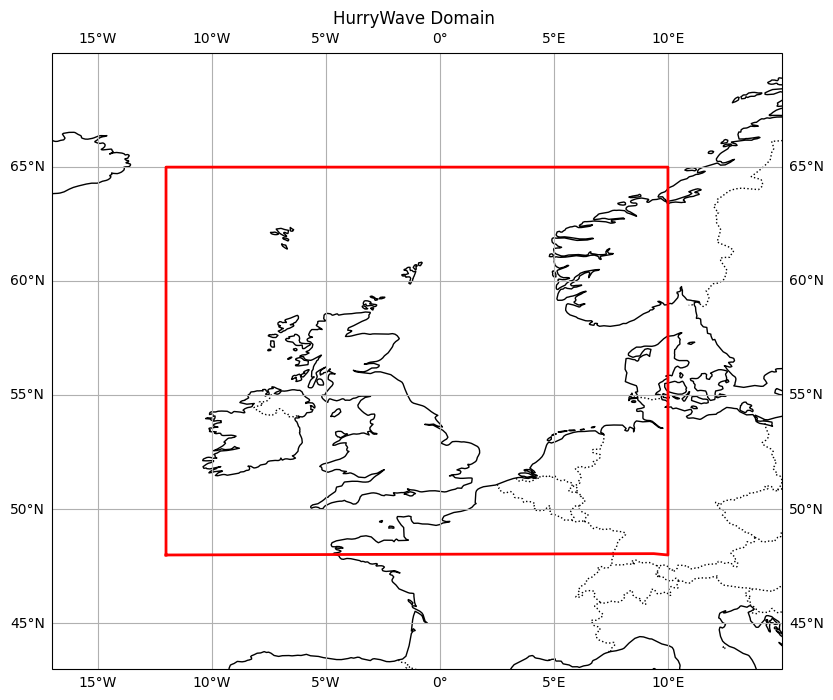

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the 4 corners of your domain
lon_min = -12
lon_max = 10
lat_min = 48
lat_max = 65

# Create figure and add basemap
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines
ax.gridlines(draw_labels=True)

# Plot the rectangle (domain box)
lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.Geodetic())

# Set extent to zoom to your domain with a little padding
ax.set_extent([lon_min - 5, lon_max + 5, lat_min - 5, lat_max + 5], crs=ccrs.PlateCarree())

# Add a title
plt.title("HurryWave Domain ")

plt.show()

In [6]:
# Observation points

# Define the observation points for the model run

Use_custom_obs = True
observation_points_regular = HurryWaveObservationPointsRegular(hw)
observation_points_spectra = HurryWaveObservationPointsSpectra(hw)

def get_lat_lon_values_from_data(data):
    """
    Get the latitude and longitude values from the dataset.
    """
    lat = data.latitude.values if 'latitude' in data.dims else None
    lon = data.longitude.values if 'longitude' in data.dims else None
    return lat, lon

latitudes,longitudes = get_lat_lon_values_from_data(era_5_data_wind)
if Use_custom_obs:
    custom_x = [3.27503678, 2.93575, 4.15028575, 1.166099, 3.218932, 4.01222222, 4.05698307, 3.81700]
    custom_y = [51.99779895, 54.32566667, 52.92535269, 61.338188, 53.21701, 54.11666667, 52.54921399, 55.41700]

    # Define transformer from WGS84 (EPSG:4326) to ETRS89 (EPSG:4258)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:4258", always_xy=True)
    custom_x_etrs89, custom_y_etrs89 = transformer.transform(custom_x, custom_y)
    custom_names = ['Euro platform','Platform D15-A','Platform Hoorn Q1-A','North Cormorant','K13 Alpha','Platform F16-A','IJmuiden munitiestortplaats', 'A12 platform']
    
    # Write to file
    obs_file = os.path.join(model_setup, 'hurrywave.obs')
    with open(obs_file, 'w') as f:
        for lon, lat, name in zip(custom_x_etrs89, custom_y_etrs89, custom_names):
            f.write(f"{lon:.6f} {lat:.6f} # {name}\n")
    
    osp_file = os.path.join(model_setup, 'hurrywave.osp')
    with open(osp_file, 'w') as f:
        for lon, lat, name in zip(custom_x_etrs89, custom_y_etrs89, custom_names):
            f.write(f"{lon:.6f} {lat:.6f} # {name}\n")

      
else:
    obs_file = os.path.join(model_setup, 'hurrywave.obs')
    osp_file = os.path.join(model_setup, 'hurrywave.osp')

    # Add the wave buoy measurements
    observation_points_regular.write()
    observation_points_spectra.write()

NameError: name 'era_5_data_wind' is not defined

eof


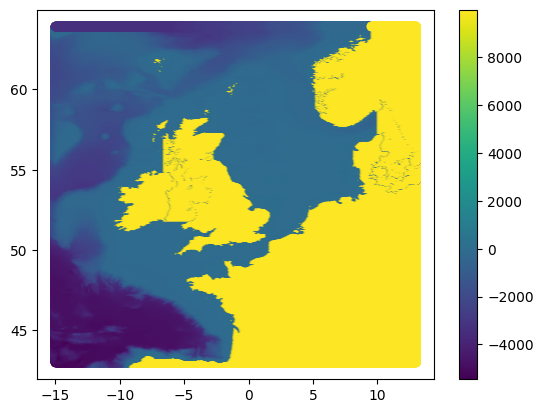

In [7]:
# Bottom grid
x0_b = -15
y0_b = 43
m_bot = 1120
n_bot = 1260
dx_bot = 0.025
dy_bot = 0.0166

x_bot = np.linspace(x0_b, x0_b + m_bot * dx_bot , m_bot + 1)
y_bot = np.linspace(y0_b, y0_b + n_bot * dy_bot , n_bot + 1)


xgr_bot, ygr_bot = np.meshgrid(x_bot, y_bot)

def read_swn_bot(filePath, idla=3, missing_value = 999):
    
    if idla==3:
        fid = open(filePath)
        dep = []
        while True:
            line = fid.readline()

            if (''==line):
                print('eof')
                break
            
            dep.append([float(x) for x in line[:-1].split()])

        dep = np.array(dep)
        dep[dep==missing_value] = np.nan
        return dep
    else:
        print('other idla\'s not yet scripted')


botfile = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/SWAN_Noordzee.bot'
dep = read_swn_bot(botfile, idla=3)
dep = dep * -1 
#%%
plt.scatter(xgr_bot[:], ygr_bot[:], c=dep[:])
plt.colorbar()

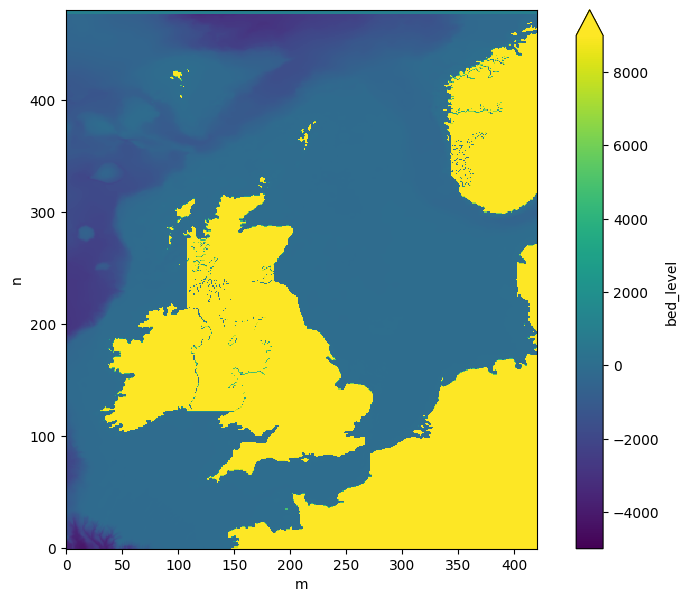

In [8]:
#%% create grid
grid = HurryWaveGrid(hw)

hw.grid = grid

hw.grid.set_bathymetry_from_other_source(xgr_bot, ygr_bot, dep, rectilinearSourceData=False)

hw.grid.write_dep_file()

fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.set_aspect("equal")
im = hw.grid.ds["bed_level"].plot(ax=ax, vmin=-5000, vmax=9000)

#%%

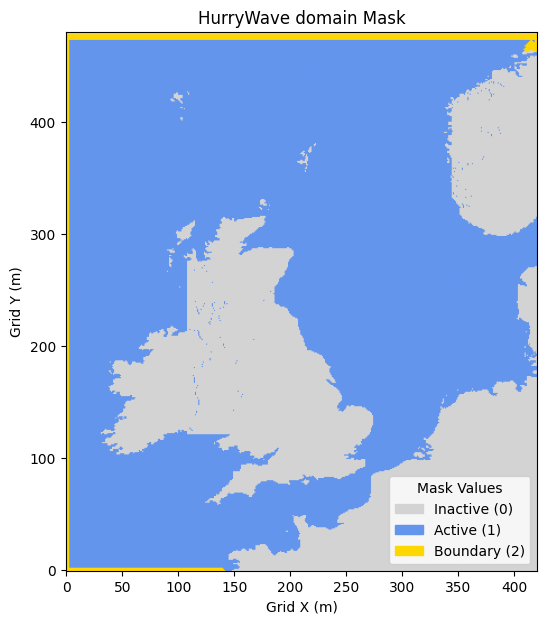

In [54]:
#% Mask 
# Initialize polygons as None
include_polygon = None
exclude_polygon = None
boundary_polygon = None

# Write open boundary polygon to file
open_bound_file = os.path.join(model_setup, "open_bound.pli")
with open(open_bound_file, "w") as f:
    f.write("boundaries_1\n")
    f.write("8  2\n")
    f.write("-5.00  47.0\n")
    f.write("-5.00  48.5\n")
    f.write("-11.0  48.5\n")
    f.write("-11.0  63.5\n")
    f.write("10.0  63.5\n")
    f.write("10.0  64.5\n")
    f.write("-14.0  64.5\n")
    f.write("-14.0  47.0\n")


open_boundary_polygon = os.path.join(model_setup, "open_bound.pli")


polygons = read_pli_file(open_boundary_polygon)
polygon_list = []

for polygon in polygons:
    polygon_list.append(MaskPolygon(x=polygon.x,
                            y=polygon.y,
                            zmin=-9999,
                            zmax=1) ) 


# mask = HurryWaveMask(grid, bathymetry.z,
#             zmin= -9999,
#             zmax=0, 
#             open_boundary_polygons= polygon_list
#             )

# Convert polygon_list to a GeoDataFrame
polygon_geometries = [Polygon(zip(polygon.x, polygon.y)) for polygon in polygons]
polygon_gdf = gpd.GeoDataFrame({'geometry': polygon_geometries}, crs="WGS 84")
hw.grid.build_mask(
            zmin= -9999,
            zmax=0, 
            boundary_polygon= polygon_gdf
            )


hw.grid.write_msk_file()

# fig, ax = plt.subplots(1,1, figsize = (10,7))
# ax.set_aspect("equal")
# im = hw.grid.ds["mask"].plot(ax=ax)
# plt.show()

from scipy.ndimage import binary_dilation
from matplotlib import cm
from matplotlib.colors import ListedColormap

mask = hw.grid.ds.mask.values.copy()
boundary = (mask == 2)
dilated = binary_dilation(boundary, iterations=2)
mask_dilated = np.where(dilated, 2, mask)


# plot
fig, ax = plt.subplots(figsize=(10,7))
ax.set_aspect("equal")
ax.imshow(mask_dilated, origin="lower")
ax.set_title("HurryWave domain Mask")
ax.set_xlabel("Grid X (m)")
ax.set_ylabel("Grid Y (m)")
import matplotlib.patches as mpatches

# Define colors and labels for the mask values
colors = {0: "lightgray", 1: "cornflowerblue", 2: "gold"}
labels = {0: "Inactive (0)", 1: "Active (1)", 2: "Boundary (2)"}

# Create legend handles
handles = [mpatches.Patch(color=colors[val], label=labels[val]) for val in sorted(colors.keys())]

# Set the colormap for the image to match the legend
cmap_mask = ListedColormap([colors[val] for val in sorted(colors.keys())])
im = ax.imshow(mask_dilated, origin="lower", cmap=cmap_mask)

# Add the legend
ax.legend(handles=handles, loc="lower right", title="Mask Values")






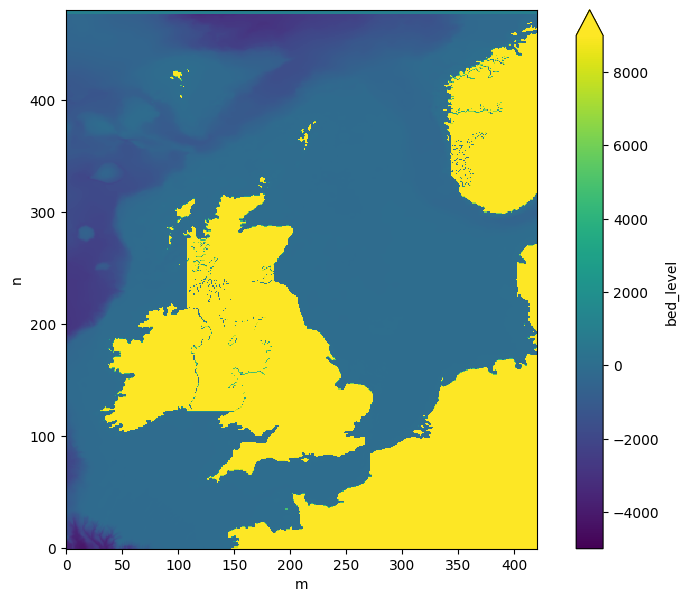

In [ ]:
old_bathy = hw.grid.ds["bed_level"].values

def change_bathy(hw,surge, old_bathy, plot = True):
    """
    Change the bathymetry of the model based on surge or tide
    :param hw: HurryWave object
    :param surge: Surge value to be added to the bathymetry
    :param old_bathy: Old bathymetry to be modified
    :param plot: Boolean to plot the new bathymetry
    :return: new bathymetry
    """
    surge = 0
    surge = surge * -1 # Convert to bottom depth change

    mask = hw.grid.ds.mask.values

    # Add the surge to the bathymetry on the active grid points
    new_bathy = old_bathy.copy()
    new_bathy[mask == 1] = old_bathy[mask == 1] + surge

    # Set the new bathymetry in the model
    hw.grid.ds["bed_level"].values = new_bathy
    hw.grid.write_dep_file()


    if plot:
        fig, ax = plt.subplots(1,1, figsize = (10,7))
        ax.set_aspect("equal")
        im = hw.grid.ds["bed_level"].plot(ax=ax, vmin=-5000, vmax=9000)

    return new_bathy

new_bathy = change_bathy(hw, surge, old_bathy)

In [ ]:
netcdf_path = output_file
meteo_grid = MeteoGrid(name = "era5",
                       source="ECMWF",
                       parameters=["wind"],
                       path=output_file,
                       x_range=[-12,10],
                       y_range=[48,65],
                       xystride=1,
                       tstride=1)

meteo_grid.collect_based_netcdf(path = netcdf_path)


meteo_grid.write_to_delft3d(os.path.join(hw.path, "hurrywave"))

hw.input.variables.amufile = "hurrywave.amu"
hw.input.variables.amvfile = "hurrywave.amv"

Latitude is decreasing (North to South), flipping it...


In [ ]:
#%% write the total model to file
hw.write()

# %%